# CNN in action: the MNIST challenge<a id="Top"></a>

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>
Table of Content
<ul>
<li>1. Introduction</li>
<li>2. <a href="#Part_2">Data exploration</a></li>
    <ul>
        <li>2.1 <a href="#Part_2_1">Auxiliary functions for data preprocessing and visualization</a></li>
        <li>2.2 <a href="#Part_2_2">Data preprocessing</a></li>
    </ul>    
<li>3. A simple convolutional neural network, Part 1: Basic approach</li>
    <ul>
        <li>3.1 <a href="#Part_3_1">Building and training the CNN</a></li>
        <li>3.2 <a href="#Part_3_2">Analyzing model performance</a></li>
        <li>3.3 <a href="#Part_3_3">Image enhancement using Scikit-image</a></li>
        <li>3.4 <a href="#Part_3_4">Image augmentation</a></li>
    </ul>
<li>4. A simple convolutional neural network, Part 2: Fighting against overfitting</li>
    <ul>
        <li>4.1 <a href="#Part_4_1">Retraining the model using the <tt>fit_generator</tt> method</a></li>
        <li>4.2 <a href="#Part_4_2">Visualizing filters</a></li>
    </ul>
<li>5. <a href="#Part_5">Summary</a></li>    
</ul>
</font>
</div>

__Note: Checkpoints of the trained networks and relavent Python pickle image files are stored in the tarball `./datasets/mnist.tgz`. You could find the file in the repository. If you don't want to spend time training the model, you could load the network checkpoints and play with them.__

## 1. Introduction

In this notebook we build a convolutional neural network using Keras and apply the network to the 
MNIST dataset. Through examining the network's performance, we explore one of the most common issues 
in machine learning: overfitting. Fortunately, Keras provides a toolset to tackle the issue. Next 
we dive a bit deeper into the model and examine the response of filters in convolutional layers. 
The filters represent how the model sees the input images. The results give us hints on how to build 
a better model.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import pickle
from keras import layers
from keras import models
from keras import optimizers
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.preprocessing import image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
from skimage import img_as_ubyte

Using TensorFlow backend.


## 2. Data exploration <a id="Part_2"></a>
<a href="#Top">Back to page top</a>

Keras comes with the MNIST dataset, which can be imported using 

```python
    from keras.datasets import mnist
```

The dataset then can be loaded using the class method `load_data()`:

In [2]:
(train_images, train_labels), (x_test, y_test) = mnist.load_data()
train_images.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

The training and test sets have 60,000 and 10,000 images respectively. Let's do a simple statistics on the training label.

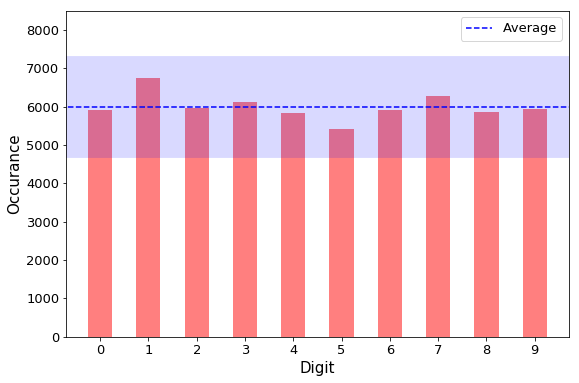

In [3]:
h, b = np.histogram(train_labels, bins=10, range=(0,10))
sigma = h.std()/np.sqrt(10.0)

plt.figure(figsize=(9,6))
plt.bar(b[:-1], h, width=0.5, fc='r', alpha=0.5)
plt.hlines(h.mean(), -1, 10, colors='b', linestyle='dashed', label='Average')
plt.hlines(h.mean(), -1, 10, colors='b', linewidth=sigma, alpha=0.15)
plt.xlim([-0.7, 9.7])
plt.ylim([0,8500])
plt.xlabel('Digit', fontsize=15)
plt.ylabel('Occurance', fontsize=15)
plt.xticks([0,1,2,3,4,5,6,7,8,9], fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)
plt.show()

The dashed blue line is the average, and the transparent blue region represents one standard deviation $\sigma$ below and above the average. So it appears that the 10 digits have more or less the same number of occurance, all within one $\sigma$.

### 2.1 Auxiliary functions for data preprocessing and visualization <a id="Part_2_1"></a>
<a href="#Top">Back to page top</a>

Here we will define functions for data preprocessing and visualization. They include:

- `plot_digit()`: Plots the image of a given digit and, optinally, prints its label.
- `plot_history()`: Plot training and validation metrics.
- `plot_predictions()`: Visualize predictions and ground truth, along with digit images.
- `get_wrong_predictions()`: Get digit images whose labels that are predicted wrong.
- `image_enhancement()`: Demonstarte `skimage` image enhancement utilities.

In [4]:
def plot_digit(x, y):
    '''
    Thus function plots the image of x and, optionally, prints its label if provided.
    Input:
        x: Grey scale image of the digit, i.e. we are assuming there is only one channel. 
           The dimension could be (28, 28) or (28, 28, 1). 
        y: A list of category probabilities. The label is the category that has the 
           maximum probability.
    '''
    plt.imshow(x.reshape(28,28), cmap = matplotlib.cm.binary)
    plt.axis('off')
    print('label:', np.argmax(y))    
    plt.show()



# -------------------------------------------------------------------------------
def preprocess(x):
    '''
    The function preprocesses the dataset x.
    '''
    norm = 255.0    
    x = x.reshape(x.shape + (1,))
    x = x.astype('float32') / norm
    
    return x


# -------------------------------------------------------------------------------
def plot_history(history, ymin=0.9, ymax=1.0):
    '''
    Simple function that plots metrics in the Keras history class.
    '''
    acc = history.history['acc']
    loss = history.history['loss']
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc)+1)
    
    plt.figure(figsize=(8,10))
    plt.subplots_adjust(hspace=0.2)
    
    plt.subplot(211)
    plt.plot(epochs, acc,     'bo-', markersize=3, label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', markersize=3, label='Validation acc')
    plt.ylim(ymin, ymax)
    plt.xlim(0, len(acc)+1)
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend()
    
    plt.subplot(212)
    plt.plot(epochs, loss,     'bo-', markersize=3, label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', markersize=3, label='Validation loss')
    plt.xlim(0, len(acc)+1)
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend()
    
    plt.show()
    
    
    
# -------------------------------------------------------------------------------
def plot_predictions(flag, x, y, y_pred, nrows, ncols, verbose=False):
    '''
    For inspection, this function visualizes correctly or wrongly predicted labels depending on the flag.
    Inputs --
         flag: 0 -> show wrong predictions
               1 -> show correction predictions
            x: target digit images of shape (batch, height, width, channel)
            y: target digit labels, assumes the probability form.
       y_pred: label predictions, assumes the probability form.
        nrows: number of rows in the final plot
        ncols: number of columns in the final plot
      verbose: optional.
    '''
    assert flag <= 1, 'The first argument has to be 0 or 1'
    height = 28
    width = 28
    header = 10
    
    pred = np.argmax(y_pred, axis=1)
    ans = np.argmax(y, axis=1)
    fltr = ( np.array(pred) == np.array(ans) )
    if verbose:
        print(' number of correct predictions:', len(x[fltr]))
        print('   number of wrong predictions:', len(x[~fltr]))
    if flag == 0:
        digits = x[~fltr]
        labels_pred = np.array(pred)[~fltr]
        labels_ans = np.array(ans)[~fltr]
    elif flag == 1:
        digits = x[fltr]
        labels_pred = np.array(pred)[fltr]
        labels_ans = np.array(ans)[fltr]
        
    # Reshape the images for plotting    
    digits = digits.reshape(len(digits), 28, 28)
          
    # Prepare the figure  
    d = np.zeros(((height+header)*nrows, width*ncols))
    fig, ax = plt.subplots(figsize=(14,14), sharex=True, sharey=True)
    ax.axis('off')

    for i in range(nrows):
        for j in range(ncols):
            idx= i*ncols + j            
            d[i*(height+header)+header:(i+1)*(height+header), j*width:(j+1)*width] = digits[idx]
            idx = j*ncols + i
            if flag == 0:
                ax.text(i*width+9,j*(height+header)+9,labels_pred[idx], 
                        ha="center", va="center", color="b", fontsize=18)
                ax.text(i*width+19,j*(height+header)+9,labels_ans[idx], 
                        ha="center", va="center", color="r", fontsize=18)        
            elif flag == 1:
                ax.text(i*width+14,j*(height+header)+9,labels_pred[idx], 
                        ha="center", va="center", color="b", fontsize=18)                
    ax.imshow(d, cmap=matplotlib.cm.binary)
    if flag == 0:
        plt.title('blue: predictions       red: ground truth ', fontsize=20)
        plt.suptitle('Samples of wrong predictions', y=0.94, fontsize=24)
    elif flag == 1:
        plt.suptitle('Samples of correct predictions', y=0.91, fontsize=24)
    plt.show()    

    
    
# -------------------------------------------------------------------------------
def get_wrong_predictions(x, y, y_pred):
    '''
    This functions returns digits that are wrongly predicted.
    Corresponding prediction and ground truth are also returned.
    '''
    pred = np.argmax(y_pred, axis=1)
    ans = np.argmax(y, axis=1)
    fltr = ( np.array(pred) == np.array(ans) )
    print(' number of correct predictions:', len(x[fltr]))
    print('   number of wrong predictions:', len(x[~fltr]))

    digits = x[~fltr]
    labels_pred = np.array(pred)[~fltr]
    labels_ans = np.array(ans)[~fltr]
    
    return digits.reshape(len(digits), 28,28), labels_ans, labels_pred



# -------------------------------------------------------------------------------
def image_enhancement(image):
    '''
    This function demos several image enhancement methods provided by the skimage library.
    '''
    selem = disk(3.5)
    cmap = matplotlib.cm.binary
    p2, p98 = np.percentile(image, (2, 98))
    percent = 0.20

    image_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))
    image_adapteq = exposure.equalize_adapthist(img_as_ubyte(image), clip_limit=0.02)
    image_eq = exposure.equalize_hist(image)
    image_al = rank.autolevel(image, selem=selem)
    image_alp = rank.autolevel_percentile(image, selem=selem, p0=percent, p1=(1.0-percent))
    image_ec = rank.enhance_contrast(image, disk(2))
    image_ecp = rank.enhance_contrast_percentile(image, disk(2), p0=percent, p1=(1.0-percent))
    image_otsu = rank.otsu(image, disk(1))

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,8),
                             sharex=True, sharey=True)
    ax = axes.ravel()

    title_list = ['original',  'contrast streching',
                  'auto_level','auto-level {0:3.1f}%'.format(percent*100),
                  'histogram equalizer','adaptive histogram equalizer',
                  'enhance contrast', 'enhance contrast {0:3.1f}%'.format(percent*100),
                  'Otsu threshold']
    image_list = [image, image_rescale,              
                  image_al, image_alp,
                  image_eq, image_adapteq,
                  image_ec, image_ecp,
                  image_otsu]

    for i in range(0, len(image_list)):
        ax[i].imshow(image_list[i], cmap=cmap)
        ax[i].set_title(title_list[i])
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()    

### 2.2 Data preprocessing<a id="Part_2_2"></a>
<a href="#Top">Back to page top</a>

Divide the original training set into training and validation sets. Here we call scikit-learn's `train_test_split()` to carry out the task. Then we normalize the training, validation, and test sets so that the pixel value is in the range [0,1]. This step is necessary because neural networks normally take inputs with small values so that backpropagation can work. We also need to one-hot encode the targets.

In [5]:
test_size = 20000
x_train, x_val, y_train, y_val = train_test_split(train_images, 
                                                  train_labels, 
                                                  test_size=test_size, 
                                                  random_state=42)
x_train = preprocess(x_train)
x_val   = preprocess(x_val)
x_test  = preprocess(x_test)

y_train = to_categorical(y_train)
y_val   = to_categorical(y_val)
y_test  = to_categorical(y_test)

print('   training tensor shape:',x_train.shape)
print(' validation tensor shape:',x_val.shape)
print('       test tensor shape:',x_test.shape)

   training tensor shape: (40000, 28, 28, 1)
 validation tensor shape: (20000, 28, 28, 1)
       test tensor shape: (10000, 28, 28, 1)


Visualize a digit from the training set. The maximum and the minimum values of its pixels will be displayed. This is to confirm that the tensors have been properly normalized in the range [0, 1].

maximum element of the input image array: 1.0
minimum element of the input image array: 0.0
label: 9


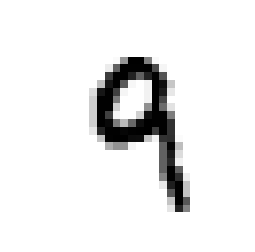

In [6]:
idx = 3722
print('maximum element of the input image array:', np.amax(x_train[idx]))
print('minimum element of the input image array:', np.amin(x_train[idx]))
plot_digit(x_train[idx], y=y_train[idx])

## 3. A simple convolutional neural network, Part 1: Basic approach

### 3.1 Building and training the CNN<a id="Part_3_1"></a>
<a href="#Top">Back to page top</a>

The model we are going to build is a rather basic CNN. It has two convolutional layers `Conv2D()` layers. After each Conv2D layer, we downsample the image by inserting a maximal pooling layer `MaxPool2D()`. The outputs from the last `Conv2D()`/`MaxPool2D()` combo are flattened and then attached to two dense layers. Since we have 10 digits, the activation function of the last layer should be a softmax function which outputs class probabilities. For the same reason, the loss function is '`categorical_crossentroty`.' And we simply monitor the model's accuracy.

In [7]:
learning_rate = 5e-4

model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(28,28,1)))
model.add(layers.MaxPool2D(2))
model.add(layers.Conv2D(64, 3, activation='relu', padding='same'))
model.add(layers.MaxPool2D(2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

model.compile(optimizer = optimizers.RMSprop(lr=learning_rate), 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.save_weights('mnist_CNN_initial_weights.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                200768    
__________

After compilation, we save the model's intial weights. They will be used to reset the model in the later stage.
Now that we have built and compiled the model, it's time to train it. The training session has 40 epochs. At each training step, the batch size is 64 instances drawn from the training set. At the end of the training session, the model (actually the trainable weights of the model) will be saved. We'll also save the Keras history instance which contains training metrics.  

In [8]:
history = model.fit(x_train, 
                    y_train,
                    batch_size = 64,
                    epochs = 40,
                    validation_data = (x_val, y_val))

model.save('mnist_CNN_model.h5')

with open('mnist_CNN_history.pickle', 'wb') as history_file:
    pickle.dump(history, history_file)

Train on 40000 samples, validate on 20000 samples
Epoch 1/40
40000/40000 [==============================] - 6s 150us/step - loss: 0.3365 - acc: 0.8969 - val_loss: 0.1008 - val_acc: 0.9700
Epoch 2/40
40000/40000 [==============================] - 5s 123us/step - loss: 0.1067 - acc: 0.9665 - val_loss: 0.0734 - val_acc: 0.9797
Epoch 3/40
40000/40000 [==============================] - 5s 123us/step - loss: 0.0759 - acc: 0.9757 - val_loss: 0.0560 - val_acc: 0.9835
Epoch 4/40
40000/40000 [==============================] - 5s 132us/step - loss: 0.0634 - acc: 0.9793 - val_loss: 0.0485 - val_acc: 0.9862
Epoch 5/40
40000/40000 [==============================] - 5s 124us/step - loss: 0.0544 - acc: 0.9825 - val_loss: 0.0483 - val_acc: 0.9859
Epoch 6/40
40000/40000 [==============================] - 5s 125us/step - loss: 0.0497 - acc: 0.9841 - val_loss: 0.0438 - val_acc: 0.9872
Epoch 7/40
40000/40000 [==============================] - 5s 127us/step - loss: 0.0443 - acc: 0.9857 - val_loss: 0.0419 - 

### 3.2 Analyzing model performance<a id="Part_3_2"></a>
<a href="#Top">Back to page top</a>

Now let's load the training history instance and plot the metrics.

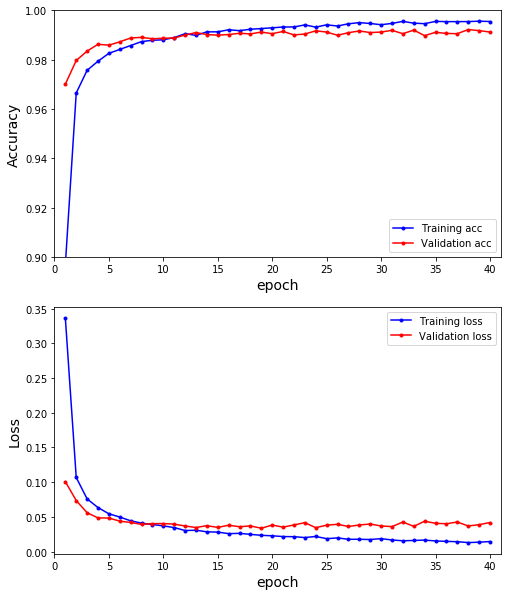

In [10]:
h = pickle.load( open('mnist_CNN_history.pickle', 'rb'))
plot_history(h, ymin=0.9)

We can see that the training loss keeps dropping, but the validation loss sees no improvement starting roughly from epoch 8$\sim$9. This is a classic case of overfitting, even though we have added a dropout layer. The comparison between the training and validation curves indicates that at the end of 40 epochs, the network overfits the training set and doesn't generalize well to the validation set. The networks's actual In all machine learning tasks, what really matters is the model's ability to generalize to data it has never seen before. 

Let's evaluate the network using the test set:

In [11]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(' test accuracy:', test_acc)

10000/10000 [==============================] - 1s 69us/step
 test accuracy: 0.9922


99.2% accuracy is not too bad. But given that the model is overfitted, this number is perhaps not that reliable. 

To take a closer look at what was going on, let's load the last model snapshot and analyze its predictions on the validation set.

In [12]:
m = models.load_model('mnist_CNN_model.h5')

Generate predictions on the validation set.

In [13]:
y_pred = m.predict(x_val, verbose=1)

20000/20000 [==============================] - 2s 80us/step


Next, let's visualize the digits that the network have mis-predicted. Here we deploy the function `get_wrong_predictions()` defined earlier.

In [14]:
wrong, ans, pred = get_wrong_predictions(x_val, y_val, y_pred)

 number of correct predictions: 19823
   number of wrong predictions: 177


Plotting the correct predictions:

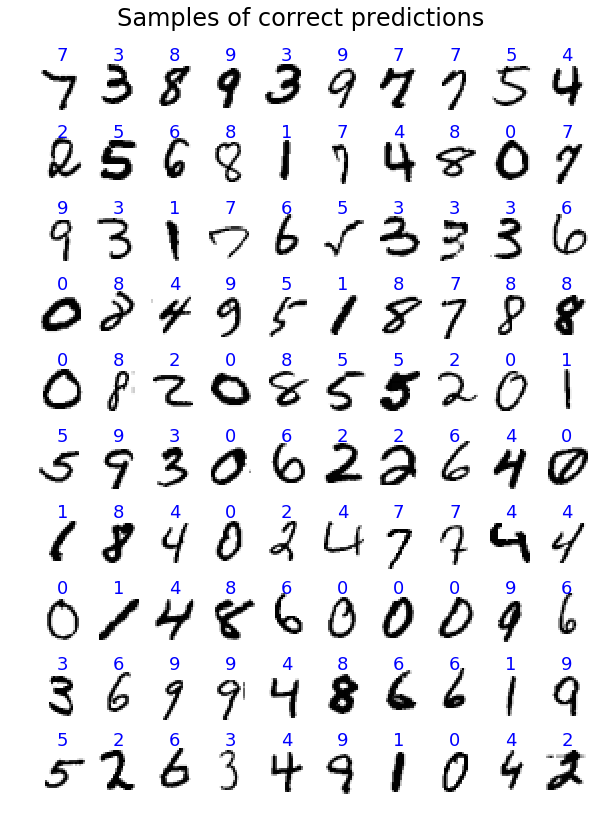

In [15]:
plot_predictions(1, x_val, y_val, y_pred, 10, 10)

For comparison, the following are the digits that the network got it wrong, along with the ground truth (red numbers).

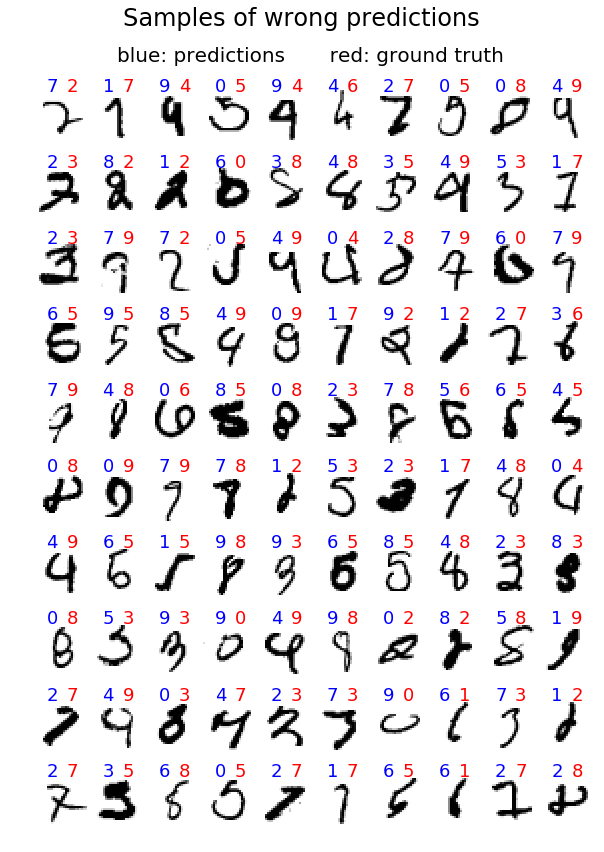

In [16]:
plot_predictions(0, x_val, y_val, y_pred, 10, 10)

Two observations concerning the collection that the network got it wrong:

2. In the set, many digits are distorted. 
3. It seems that the network made wrong predictions based on local features it learned from what it believed to be the ground truth.

Both observations point the the lack of ability for the network to generalize, a symptom of overfitting training set.
We'll work on the data set in such a way that the resulting training data can help the network generalize.

### 3.3 Image enhancement using Scikit-image<a id="Part_3_3"></a>
<a href="#Top">Back to page top</a>

Image enhancement techniques are quite standard in digital postprocessing. Packages such as Photoshop or Lightroom have them already: level, saturation, contrast, histogram, etc. Needless to say, it is impractical to preprocess image data using these software packages. Fortunately, at leat for Python users, <a href="https://scikit-image.org/">scikit-image</a> provides an excellent collection of image processing tools. 
Scikit-image is avaiable through either <tt><a href="https://pypi.org/project/scikit-image/">pip</a></tt> or <tt><a href="https://anaconda.org/anaconda/scikit-image">anaconda</a></tt>. Once installed, it can be imported through the standard way:
```python
    import skimage
```
Within Scikit-image library images are represented by NumPy arrays, which are exactly the objects that Keras operates on. Scikit-Image's documentation provides tons of processing examples for grey scale images. Here we'll just demonstrate 8 simple image enhancement techniques:

1. Contrast stretching
2. Auto level
3. Percentile auto level
4. Histogram equalizer
5. Adaptive histogram quializer
6. Contrast enhancement
7. Percentile contrast enhancement
8. Otsu threshold

Let's apply them and see to what level the image can be enhanced. Take a number from the wrong sample, say number 9 in the 7th row.


   prediction: 4
 ground truth: 8 



/home/chiachen/miniconda3/envs/mlenv-gpu/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


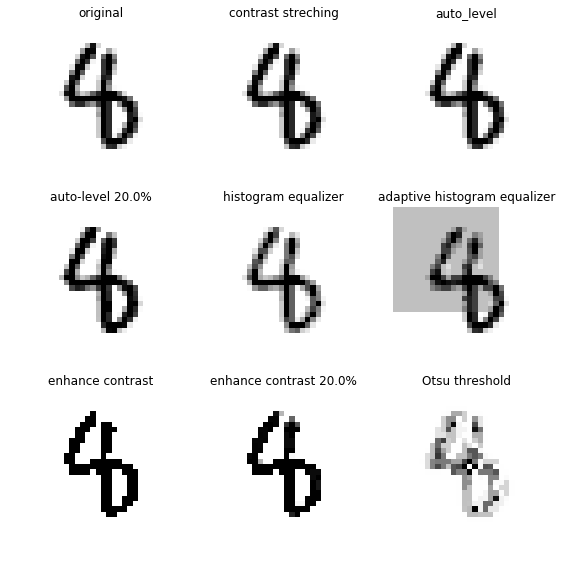

In [17]:
id = 67
print('\n   prediction:', pred[id])
print(' ground truth:', ans[id], '\n')
image_enhancement(wrong[id])

In general, contrast enhancement sharpens the edges of the image. Histogram equalizer (global or local) effectively does the opposite: blurrs the edges. The adaptive histogram equalizer unfortunately creates a patch of artifact pixels. For the purpose of demonstration, we'll process the training set using the Percentile Auto Level. Other
methods might be useful in your future image recognization projects.

### 3.4 Image augmentation<a id="Part_3_4"></a>
<a href="#Top">Back to page top</a>

Data augmentation is especially useful the there are too few samples for training, giving the model a hard time to generalize well. It is an approach of generating new data from existing training samples by augmenting them through a number of randomly chosen transformations. So the model, in effect, will never see the same data twice. This, hopefully, will expose the model to more aspects of the data and make the model generalize better.

For image data, Keras provides the <a href="https://keras.io/preprocessing/image/#imagedatagenerator-class">ImageGenerator instance</a> that can carry out the transformation for you. The following major transformations are available:
1. Rotation
2. Width shift
3. Height shift
4. Brightness shift
5. Shear
6. Zoom
7. Horizontal flip
8. Vertical flip
9. Rescale

Let's use an example to demonstrate the augmentation tools. First, we randomly pick a number from the training set.

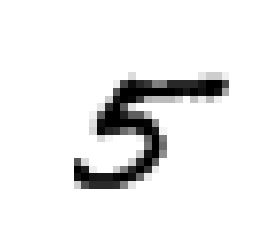

shape: (28, 28, 1)


In [18]:
id = 91
digit = x_val[id]
plt.imshow(digit.reshape(28,28), cmap=matplotlib.cm.binary)
plt.axis('off')
plt.show()
print('shape:', digit.shape)

The ImageGenerator take 4D tensor of shape `(batch, height, width, channel)`, so we have to reshape the image.

In [19]:
digit = digit.reshape((1, ) + digit.shape)
digit.shape

(1, 28, 28, 1)

Now it's time to define the generator:

In [20]:
img_generator = image.ImageDataGenerator(
                    rotation_range     = 40,
                    width_shift_range  = 0.15,
                    height_shift_range = 0.15,
                    shear_range        = 10,
                    zoom_range         = 0.3,
                    horizontal_flip    = False,
                    vertical_flip      = False )

Note that in this example, the horizontal and vertical flips are deliberately turned off. This is because not all images still make sense under these transformations. For example, it we flip the numbers 2, 3, 4, 5, 6, 7, and 9, the results would make complete nonsense. We also bypass rescale. This transformation rescales the pixel density. Since we have rescaled the data to the range [0.0, 1.0], the transformation is no longer needed.

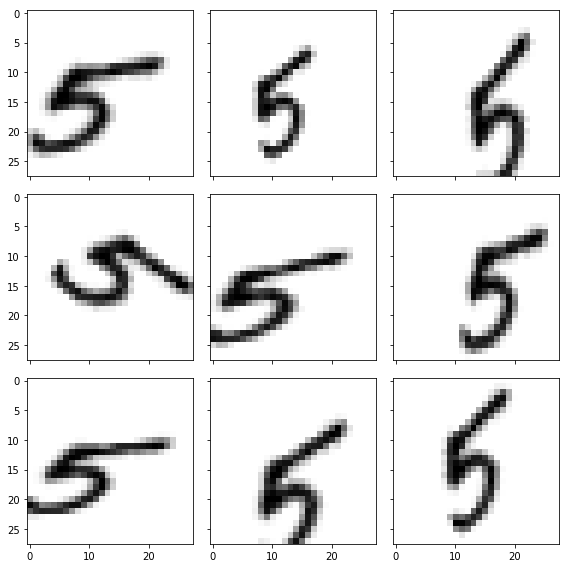

In [21]:
i = 0
image_list = []
for x in img_generator.flow(digit, batch_size=1):
    image_list.append(x.reshape(28,28))
    i += 1
    if i%9 ==0:
        break
        
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,8),
                             sharex=True, sharey=True)
ax = axes.ravel()                      
for i in range(0, len(image_list)):
    ax[i].imshow(image_list[i], cmap=plt.cm.binary)
plt.tight_layout()
plt.show()

Note that during training, the transformations are applied randomly. So you will need see every transformation in effect. But for batch training, the random transformation serves our purpose perfectly.

## 4.  A simple convolutional neural network, Part 2: Fighting against overfitting

### 4.1  Retraining the model using the <tt>fit_generator</tt> method<a id="Part_4_1"></a>
<a href="#Top">Back to page top</a>

We have explored two useful image preprocessing techniques: __enhancement__ and __augmentation__. In this part, we will retrain the model from scratch and add the following ingredients:

1. Preprocess the training set using Percentile Auto Level.
2. Use image augmentation generator to generate new image batches during training.

First, define the auto level function.

In [22]:
def PercentileAutoLevel(image):
    '''
    This function demos several image enhancement methods provided by the skimage library.
    '''
    selem = disk(3.5)
    percent = 0.20

    output = []
    count = 0
    for x in image:
        x = rank.autolevel_percentile(x.reshape(28,28), selem=selem, p0=percent, p1=(1.0-percent))/255.0
        count += 1
        output.append(x)
        if count%1000 == 0:
            print('batch {} processed.'.format(count))
    return np.array(output).reshape(image.shape)

Call the auto level function to process the training set

In [23]:
x_train_autoleveled = PercentileAutoLevel(x_train)

batch 1000 processed.
batch 2000 processed.
batch 3000 processed.
batch 4000 processed.
batch 5000 processed.
batch 6000 processed.
batch 7000 processed.
batch 8000 processed.
batch 9000 processed.
batch 10000 processed.
batch 11000 processed.
batch 12000 processed.
batch 13000 processed.
batch 14000 processed.
batch 15000 processed.
batch 16000 processed.
batch 17000 processed.
batch 18000 processed.
batch 19000 processed.
batch 20000 processed.
batch 21000 processed.
batch 22000 processed.
batch 23000 processed.
batch 24000 processed.
batch 25000 processed.
batch 26000 processed.
batch 27000 processed.
batch 28000 processed.
batch 29000 processed.
batch 30000 processed.
batch 31000 processed.
batch 32000 processed.
batch 33000 processed.
batch 34000 processed.
batch 35000 processed.
batch 36000 processed.
batch 37000 processed.
batch 38000 processed.
batch 39000 processed.
batch 40000 processed.


Next we fit the generator defined earlier to the new training set.

In [24]:
img_generator.fit(x_train_autoleveled)

The training set generator is obtained using the <tt>flow</tt> method of the generator instance. Here we put in the training set and corresponding labels. The batch size is also defined at this stage.

In [25]:
train_generator = img_generator.flow(x_train_autoleveled, y_train, batch_size=64)

Now we reset the model by loading the initial weights saved at the beginning.

In [26]:
model.load_weights('mnist_CNN_initial_weights.h5')

The same model has been compiled in the first part. There is no need to recompile the model. So we just retrain the model using the `fit_generator` method of the model instance. One has to specify the number of training steps per epoch. Again, the model and training history will be saved at the end of the session.

In [27]:
steps = len(x_train_autoleveled) // 64
print('  Training steps per epoch:', steps)

history2 = model.fit_generator( train_generator,
                                steps_per_epoch = steps,
                                epochs = 40,
                                validation_data = (x_val, y_val) )

model.save('mnist_CNN_model_2.h5')

with open('mnist_CNN_history_2.pickle', 'wb') as history_file:
    pickle.dump(history2, history_file)

  Training steps per epoch: 625
Epoch 1/40
625/625 [==============================] - 7s 11ms/step - loss: 1.2427 - acc: 0.5819 - val_loss: 0.2702 - val_acc: 0.9341
Epoch 2/40
625/625 [==============================] - 7s 11ms/step - loss: 0.6506 - acc: 0.7977 - val_loss: 0.1715 - val_acc: 0.9537
Epoch 3/40
625/625 [==============================] - 7s 11ms/step - loss: 0.4699 - acc: 0.8564 - val_loss: 0.1510 - val_acc: 0.9574
Epoch 4/40
625/625 [==============================] - 7s 11ms/step - loss: 0.3819 - acc: 0.8866 - val_loss: 0.1344 - val_acc: 0.9626
Epoch 5/40
625/625 [==============================] - 7s 11ms/step - loss: 0.3371 - acc: 0.8981 - val_loss: 0.1159 - val_acc: 0.9673
Epoch 6/40
625/625 [==============================] - 7s 11ms/step - loss: 0.3009 - acc: 0.9086 - val_loss: 0.1004 - val_acc: 0.9698
Epoch 7/40
625/625 [==============================] - 7s 11ms/step - loss: 0.2759 - acc: 0.9151 - val_loss: 0.1005 - val_acc: 0.9711
Epoch 8/40
625/625 [=================

Let's load and plot the training history.

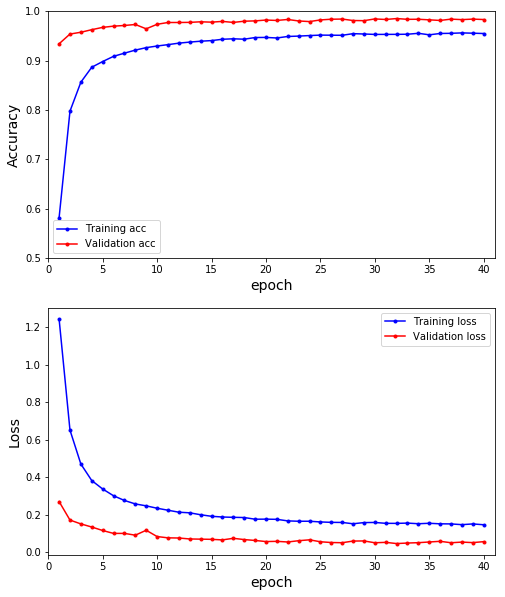

In [28]:
h2 = pickle.load( open('mnist_CNN_history_2.pickle', 'rb'))
plot_history(h2, ymin=0.5)

In [29]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(' test accuracy:',test_acc)

10000/10000 [==============================] - 0s 50us/step
 test accuracy: 0.9823


Clearly, the validation loss is below the training loss through the training session. We have successfully remove the overfitting problem. The test accuracy computed above is __98.2%__, this is in line with the validation accuracy.

### 4.2  Visualizing filters<a id="Part_4_2"></a>
<a href="#Top">Back to page top</a>

Now that the overfitting problem is much reduced, is there a way to boost the accuracy? Let's dive a bit deeper to the model by looking at filter sets of convolutional layers. Filters in a convolutional layer represent the way how the layer sees the image. Put it in another way: Each convolutional layer features a set of filters. The inputs of the layer can then be expressed as a combination of filters. When we build the model, the number of layers is the second argument of the function `layers.Conv2D()`. We will not go through details about how to extract filter responses. Those who are interested should check F. Chollet's excellent book of Deep Learning. Here I'll just recycle his code snippets.

In [30]:
from keras import backend as K

In [31]:
# Credit: F. Chollet
def layer_filter(model, layer_name, filter_index, size=28):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])    
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random( (1, size, size, 1))*20 + 128.    
    
    step = 1.0
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    img += 0.5
    img = np.clip(img, 0, 1)
    
    return img

def ConvnetFilters(model, layer_name, filter_size, margin, nrows, ncols, figsize=(20,20)):
    results = np.zeros((nrows*filter_size+(nrows-1)*margin, ncols*filter_size+(ncols-1)*margin, 1))
    for i in range(nrows):
        for j in range(ncols):
            filter_img = layer_filter(model, layer_name, i+(j*nrows), size=filter_size)        
            h_start = i*filter_size + i*margin
            h_end = h_start + filter_size
            v_start = j*filter_size + j*margin
            v_end = v_start + filter_size
            results[h_start:h_end, v_start:v_end,:] = filter_img

    plt.figure(figsize=figsize)
    h, w = results.shape[0], results.shape[1]
    plt.title('Filter patterns for layer: {}'.format(layer_name), fontsize=24)
    plt.imshow(results.reshape(h,w))
    plt.show()

Okay, let's load the saved model and print out its layer structures.

In [32]:
m3 = models.load_model('mnist_CNN_model.h5')
m3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                200768    
__________

Our model has only two convolutioal layers named `conv2d_1` and `conv2d_2`. The first layer has 32 filters while the second one has 64 filters. With the information in mind, let's visualize the filter for both layers.

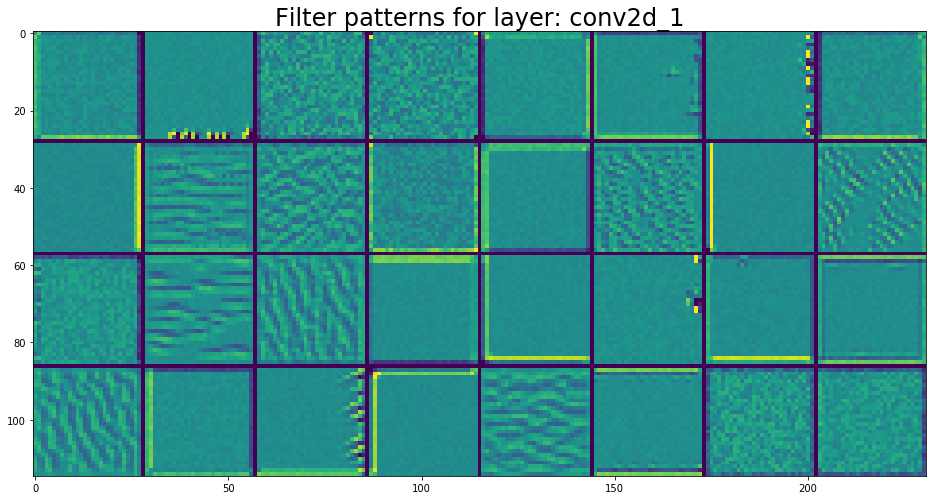

In [33]:
ConvnetFilters(m3, 'conv2d_1', filter_size=28, margin=1, nrows=4, ncols=8, figsize=(16,16))

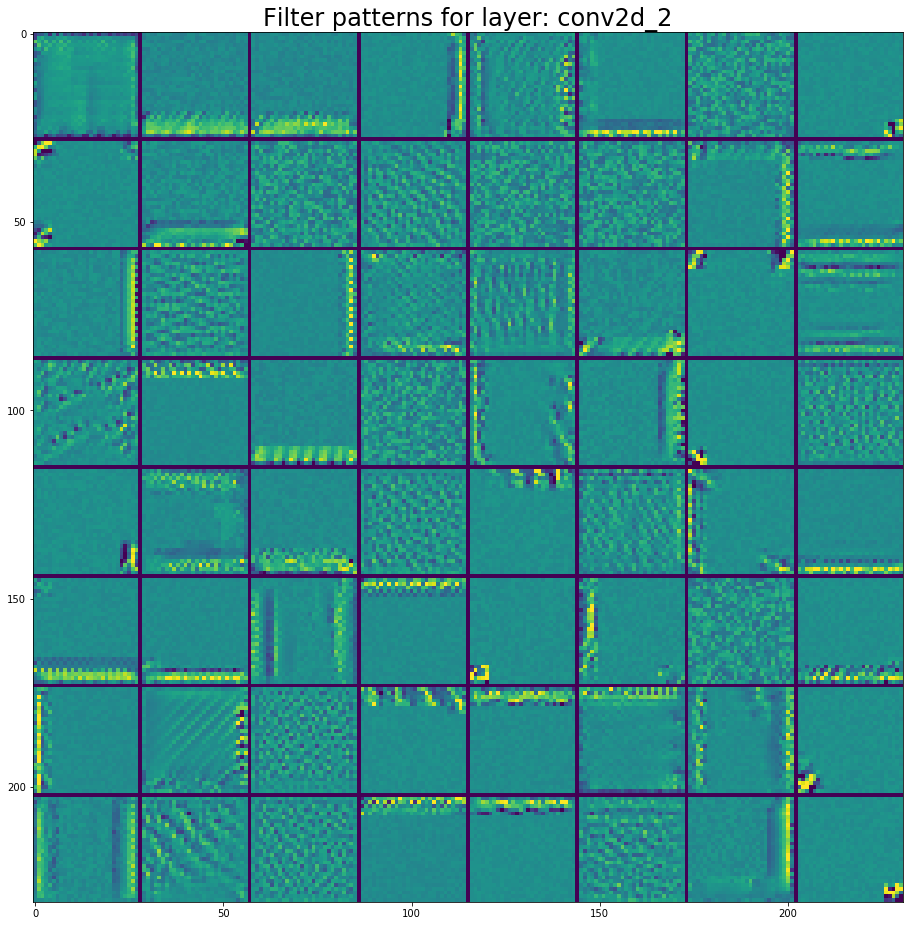

In [34]:
ConvnetFilters(m3, 'conv2d_2', filter_size=28, margin=1, nrows=8, ncols=8, figsize=(16,16))

The filters from the first layer learn a few simple patterns such as lines and dots. Moving up the the second layer, the filter response begins to show a bit more complex patterns. But most of them still only respond to simple geometric petterns. So this observation basically implies that if we could stack more layers in the model, perhaps the upper layers could capture patterns resemble textues in the input images. To verify this idea, let us build a more complex CNN model. This time, we'll stack 6 convolutional layers and 3 dense layers:

In [35]:
learning_rate=5e-4
m5 = models.Sequential()
m5.add(layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(28,28,1)))
m5.add(layers.Conv2D(32, 3, activation='relu', padding='same'))
m5.add(layers.BatchNormalization())
m5.add(layers.MaxPool2D(2))
m5.add(layers.Conv2D(64, 3, activation='relu', padding='same'))
m5.add(layers.Conv2D(64, 3, activation='relu', padding='same'))
m5.add(layers.BatchNormalization())
m5.add(layers.MaxPool2D(2))
m5.add(layers.Conv2D(128, 3, activation='relu', padding='same'))
m5.add(layers.Conv2D(128, 3, activation='relu', padding='same'))
m5.add(layers.BatchNormalization())
m5.add(layers.Flatten())
m5.add(layers.Dropout(0.5))
m5.add(layers.Dense(128, activation='relu'))
m5.add(layers.Dense(32, activation='relu'))
m5.add(layers.BatchNormalization())
m5.add(layers.Dense(10, activation='softmax'))

m5.compile(optimizer = optimizers.RMSprop(lr=learning_rate), 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
m5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
__________

The model now has one million trainable parameters. Recall our first model only has 220K paramerers. The large number of parameters means that potentially the new model has a better chance to capture the representation space defined by the training dataset. Let's train the model and plot the training history.

In [36]:
h5 = m5.fit_generator( train_generator,
                  steps_per_epoch = steps,
                  epochs = 40,
                  validation_data = (x_val, y_val),
                  verbose = 1 )

m5.save('mnist_CNN_model_3.h5')

with open('mnist_CNN_history_3.pickle', 'wb') as history_file:
    pickle.dump(h5, history_file)

Epoch 1/40
625/625 [==============================] - 13s 20ms/step - loss: 0.4933 - acc: 0.8478 - val_loss: 0.3821 - val_acc: 0.8878
Epoch 2/40
625/625 [==============================] - 12s 19ms/step - loss: 0.1632 - acc: 0.9499 - val_loss: 0.0973 - val_acc: 0.9720
Epoch 3/40
625/625 [==============================] - 12s 18ms/step - loss: 0.1264 - acc: 0.9620 - val_loss: 0.1754 - val_acc: 0.9447
Epoch 4/40
625/625 [==============================] - 12s 19ms/step - loss: 0.1058 - acc: 0.9689 - val_loss: 0.1499 - val_acc: 0.9576
Epoch 5/40
625/625 [==============================] - 12s 19ms/step - loss: 0.0926 - acc: 0.9729 - val_loss: 0.0605 - val_acc: 0.9811
Epoch 6/40
625/625 [==============================] - 12s 19ms/step - loss: 0.0862 - acc: 0.9745 - val_loss: 0.0574 - val_acc: 0.9830
Epoch 7/40
625/625 [==============================] - 12s 19ms/step - loss: 0.0839 - acc: 0.9741 - val_loss: 0.0509 - val_acc: 0.9851
Epoch 8/40
625/625 [==============================] - 12s 19ms

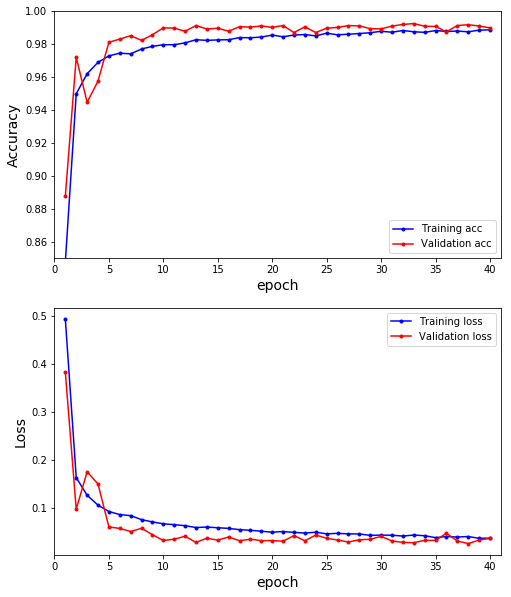

In [37]:
h5 = pickle.load( open('mnist_CNN_history_3.pickle', 'rb'))
plot_history(h5, ymin=0.85)

In [42]:
test_loss, test_acc = m5.evaluate(x_test, y_test)
print(' test accuracy:{0:8.4f}'.format(test_acc))

10000/10000 [==============================] - 1s 137us/step
 test accuracy:  0.9900


First of all, no overfitting. Good. Secondly, the test accuracy is __99.0%__,  a __0.8%__ boost in accuracy comparing the 98.2% test accuracy of the two-layer CNN model. Now let's visualize the filter sets. This time, we are going to examine filters in lower, middle, and upper layers.

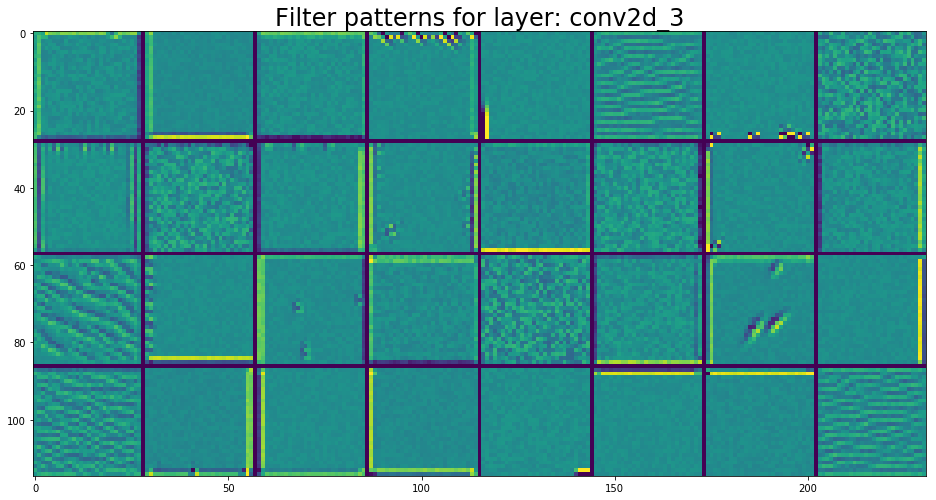

In [39]:
ConvnetFilters(m5, 'conv2d_3', filter_size=28, margin=1, nrows=4, ncols=8, figsize=(16,16))

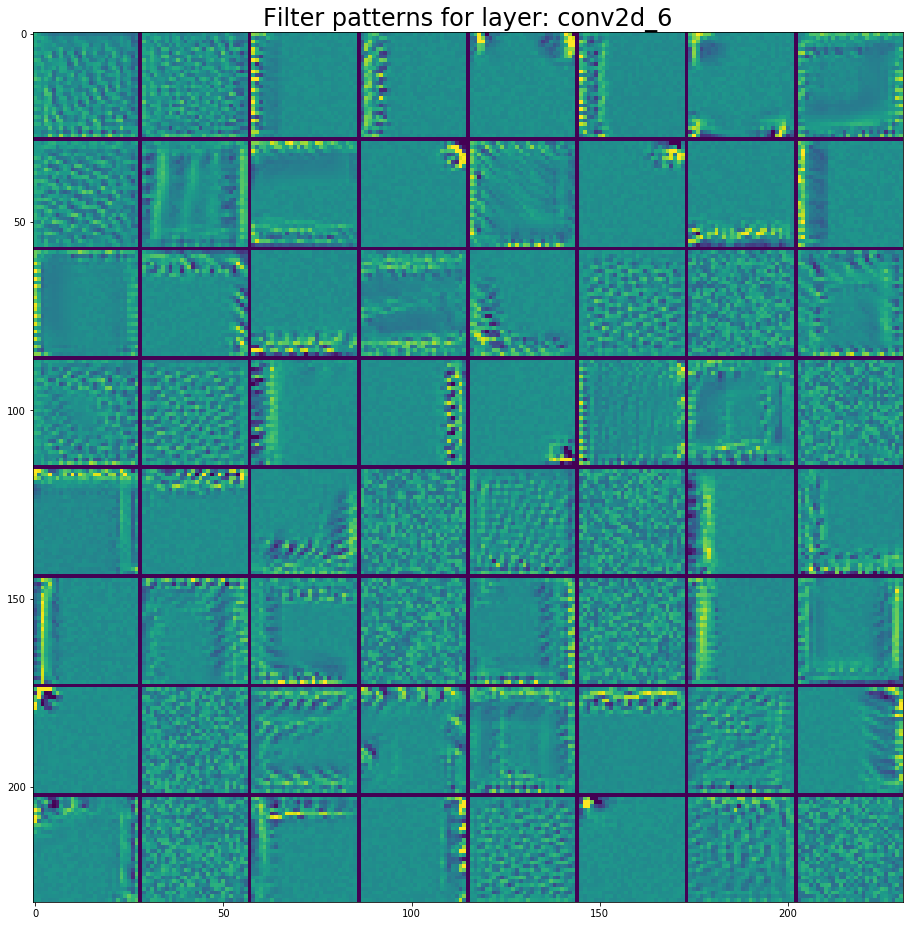

In [43]:
ConvnetFilters(m5, 'conv2d_6', filter_size=28, margin=1, nrows=8, ncols=8, figsize=(16,16))

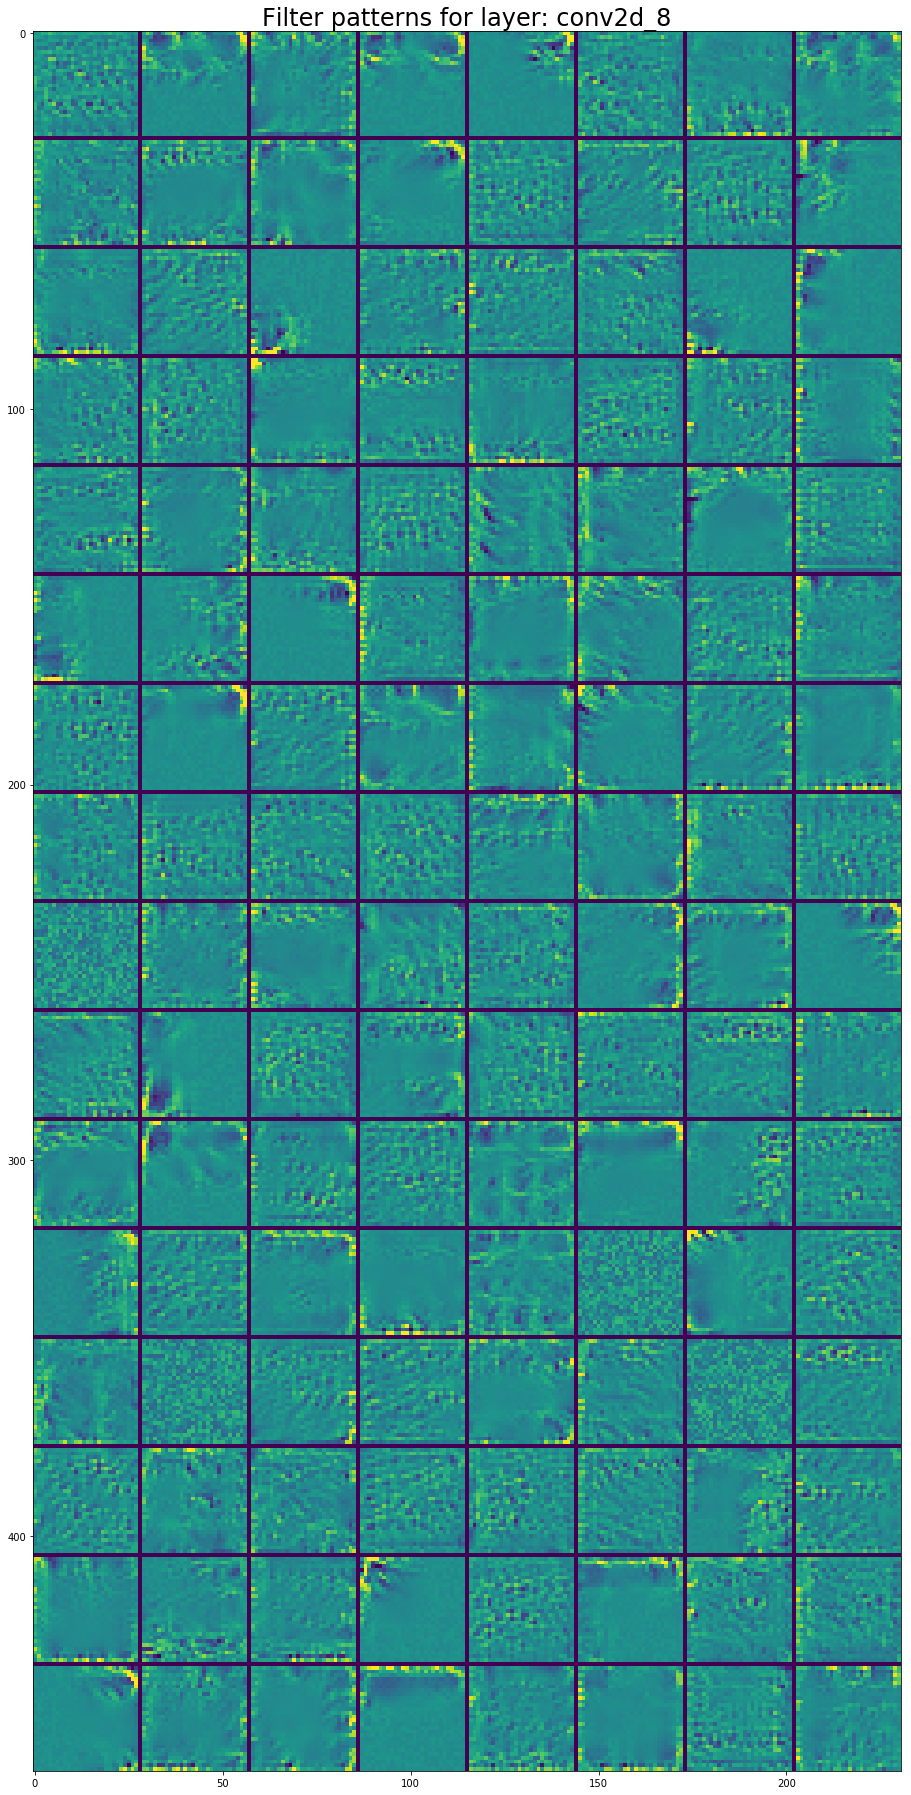

In [44]:
ConvnetFilters(m5, 'conv2d_8', filter_size=28, margin=1, nrows=16, ncols=8, figsize=(32,32))

So indeed the upper layer filters begin to capture more complex feeatures,  like circles and crosses, in the input images.

## 5. Summary<a id="Part_5"></a>
<a href="#Top">Back to page top</a>

In this notebook, we have built, trained, and evaluated convolutional neural network models and applied them 
to the MNIST dataset. The first model --- a simple two-layer CNN --- has a decent accuracy but suffers badly from overfitting. We have identified a couple potential issues and proposed methods to address the overfitting problem.
In particular, it is shown that the overfitting can be alleviated by implementing the data augmentation technique.

Due to its simple structure, the two-layer model is not able to achieve a very high accuracy. By examining responses of layer filters, it is found that the filters of the two-layer model cannot encode enough information contained in the data. Following this line of thinking, a deeper CNN model is constructed. With this more sophiscated model, the accuracy metric is improved. Visualization of filters from the upper layer show that the complex model is able to better encode features of the inputs. 

In addition to layer numbers, there are other hyperparameters that one can tune: __the size of reception field__, __channel numbers in each layer__, __padding__, __stride__, __activation funtion__, __weight initialization methods__, etc. Different network architectures may as well affect the final accuracy too. We'll leave them for you to play with.